# Setup

In [1]:
# Python >=3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >=0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import pandas as pd
assert pd.__version__ >= "0.25"
import seaborn as sns
import numpy as np
import os

# to make this notebook's output stable
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "ny_airbnb"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", 
             resolution=500):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.axis('off')
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Business Understanding

The Airbnb founder Joe Gebbia put an air matterss in his living room and turning it into a bed and breakfast in October 2007. Starting from a small idea, now Airbnb create a new business model in tourism-related accomodation and activities. Their core business is selling rooms to customers who want to stay for as long as they want at the location they want to stay. To this end, this project aims at providing "smart pricing" for New York City Airbnbs. The data is composed of 48,895 rows and 16 columns. 

#### The problem is: predict the appropriate price for AirnBnBs in NYC.

`note`: I will follow CRISP-DM

# Data Acquisition

#### Data Sources:
- AB_NYC_2019.csv (AirBnb NYC Data): https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data
- nyc_pop.csv (New York City Population By Neighborhood): https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp
- nynta (NYC Neighborhood Area): https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
- nyc_subway.csv (NYC Subway Station Data): https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49
- positive-words.txt (Lists of positive words by Minqing Hu and Bing Liu): http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
    * this includes misspelled words because it is extracted from social media content 

In [2]:
df = pd.read_csv('./new-york-city-airbnb-open-data/AB_NYC_2019.csv', parse_dates=['last_review'])

In [3]:
df.shape

(48895, 16)

In [4]:
df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null datetime64[ns]
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-nu

In [6]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


These are my first impression on the data:
* There are some missings
* `id` is uselsess featuers because each row has a unique id
* `host_name` is useless as well becase with host_id it is redundant information
* We don't need `host_id` either because we have meaningful feature that can be extracted from it - `calculated_host_listings_count`
* `latitude` & `longitude` might as well be wired to some other features and used as better representative(s)
* `name` might be helpful to extract better features out of it. 
* Numeric features are on different scales. 

# Data Understanding

### How to split data

Before we split data into test and training sets, let us see how data is distributed location wise and whether the location is related to the price.

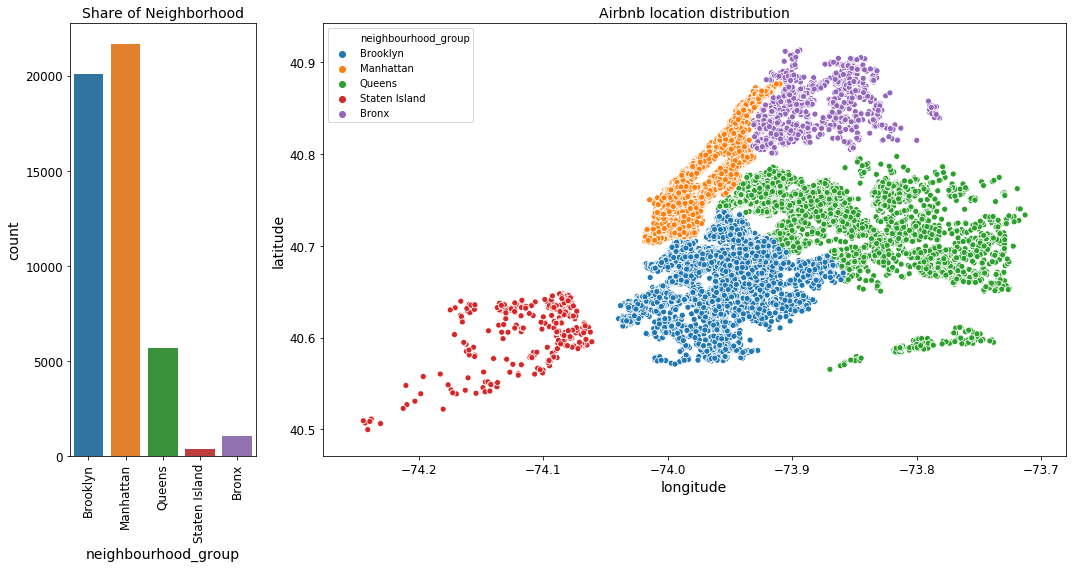

In [7]:
fig = plt.figure(figsize=((15, 8)))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1,4])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title('Share of Neighborhood', fontsize=14)
sns.countplot(x='neighbourhood_group',data=df, ax=ax1, )
plt.xticks(rotation=90)

ax2 = fig.add_subplot(gs[0,1])
ax2.set_title('Airbnb location distribution', fontsize=14)
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group', 
                data=df, ax=ax2)

plt.tight_layout()

plt.show()

Okay the majority of the data is coming from Manhattan and Brooklyn.

##### Borough wise price distribution

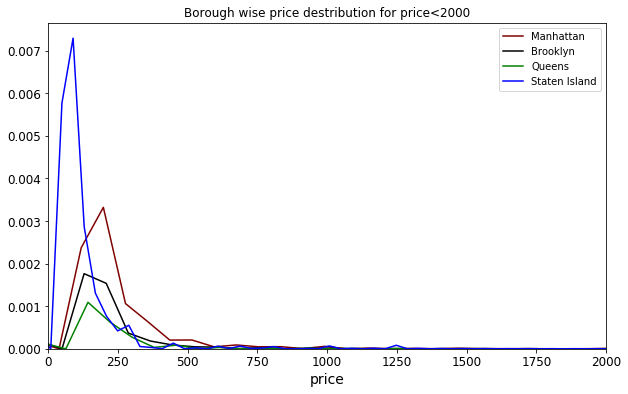

In [8]:
plt.figure(figsize=(10,6))

sns.distplot(df[df['neighbourhood_group']=='Manhattan'].price,color='maroon',
            hist=False,label='Manhattan')

sns.distplot(df[df['neighbourhood_group']=='Brooklyn'].price,color='black',
             hist=False,label='Brooklyn')

sns.distplot(df[df['neighbourhood_group']=='Queens'].price,color='green',
             hist=False,label='Queens')

sns.distplot(df[df['neighbourhood_group']=='Staten Island'].price,color='blue',
             hist=False,label='Staten Island') 

sns.distplot(df[df['neighbourhood_group']=='Long Island'].price,color='lavender',
             hist=False,label='Long Island')
plt.title('Borough wise price destribution for price<2000')
plt.xlim(0,2000)
plt.show()

Okay, price distributions based on borough are quite similar. However, Manhattan is slightly located to the right compared to others and right tails are heavier. 

/usr/local/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


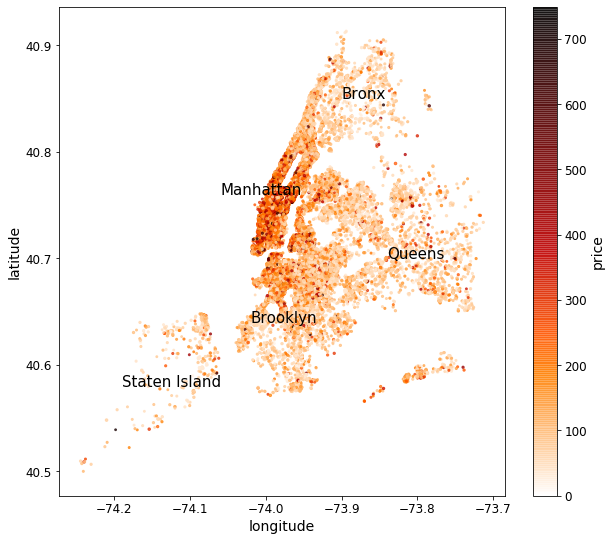

In [9]:
import geopandas as gpd
import matplotlib.image as mpimg

fig,ax = plt.subplots(1,1, figsize=(10,9))

sub_df = df[df.price<750]

sub_df.plot(kind='scatter', x='longitude',y='latitude',c='price',
            cmap=plt.get_cmap('gist_heat_r'),colorbar=True, 
            alpha=0.7, s=df.price.map(lambda x: np.log(x+1e-9)),
            ax=ax)
plt.text(-74.06, 40.76, "Manhattan", fontsize=15, color="Black")
plt.text(-73.9, 40.85, "Bronx", fontsize=15, color="Black")
plt.text(-73.84, 40.7, "Queens", fontsize=15, color="Black")
plt.text(-74.02, 40.64, "Brooklyn", fontsize=15, color="Black")
plt.text(-74.19, 40.58, "Staten Island", fontsize=15, color="Black")


plt.show()

plt.ioff()

Now, this one is interesting. High price airbnbs are congested in/around Manhattan. So it seems like where the airbnb is located is important and **our training set should reflect the distribution of `neighbourhood_group`**.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# train : test = 87.5 : 12.5
split = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
for train_index, test_index in split.split(df, df["neighbourhood_group"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    
X_train = strat_train_set.drop(columns=['price'])
y_train = strat_train_set['price'].values
X_test = strat_test_set.drop(columns=['price'])
y_test = strat_test_set['price'].values

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((42783, 15), (42783,), (6112, 15), (6112,))

### Drop unnecessary features
Let us drop `id`, `host_name` and `host_id`

In [11]:
X_train.drop(columns=['id', 'host_name', 'host_id'], inplace=True)

## Add some more features

As you notice, we only have handful features we can exploit. However, some featuers show a promise that they can be used in other form. For example, since we have location information (longitude and latitude) we can make a feature that holds the distance from the closest subway station using external data. With additional features, we can hope that we enrich the feature space and with good a good model, it shows minimum residuals from the groud truth.  I will add the following features:

- 1) `review_time_gap` : basically we transform 'last_review' to a feature that can be utilized easily by the model
- 2) `subway_distance` : using esternal data add distance to closest subway subway because I believe New York City is busy area and therefore transportation is important.
- 3) `adj_cnt` : most title should be positive and that positivity would come from how the owner paint the property with "Adjectives" and therefore i count the adjectives used in a name as a measure of name impression
- 4) `pop_density` : following 'demand and supply' rule, if the town is busier, the more people need to find a place to stay and therefore price would naturally go up. With this belief I measure the population density as a respresentative of how "hot" is the area. I use two tabulated data to extract population and area of the neighborhood. 

Later, I will see how correlated variables are to each other and prune out highly correlated features. 

### Dealing with missing values
Before we jump start featurer engineering, first things first, let us figure out what to do with "missing" values

In [12]:
X_train.select_dtypes([float, int, 'datetime']).isnull().sum()

latitude                             0
longitude                            0
minimum_nights                       0
number_of_reviews                    0
last_review                       8758
reviews_per_month                 8758
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [13]:
X_train.select_dtypes([float, int, 'datetime']).isnull().sum() / X_train.shape[0] * 100

latitude                           0.000000
longitude                          0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.470748
reviews_per_month                 20.470748
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

Remeber, there are airbnbs which do not have reviews (i.e., `number_of_reviews = 0`). If all missings in `last_review` and `reviews_per_month` are due to the fact that they do not have reviews we can defer this matter for the later time for `last_review` because `last_review` itself is hard to be used as is and we need to transform the feature into something that a model can handle more easily. As for `reviews_per_month` we can simply replace 'nan' with 0. 

In [14]:
X_train[X_train['number_of_reviews'] == 0]['reviews_per_month'].shape

(8758,)

Good! All missing values in `number_of_reviews` are from no reviews!

In [15]:
X_train['reviews_per_month'].fillna(0, inplace=True)
X_train['reviews_per_month'].isnull().sum()

0

In [16]:
X_train[X_train['number_of_reviews'] == 0]['reviews_per_month'].shape

(8758,)

Again, All missing values in `reviews_per_month` are from no reviews! For those missings, I will replace it with the "earliest date" 

In [17]:
earliest = min(X_train['last_review'])
X_train['last_review'].fillna(earliest, inplace=True)
X_train['last_review'].isnull().sum()

0

### Add `review_time_gap` feature

In [18]:
time_gap = X_train[['last_review']].applymap(lambda x: x - earliest).apply(lambda x: x.dt.days)
X_train['review_time_gap'] = time_gap.values
# drop `last_review` column
X_train.drop(columns=['last_review'], inplace=True)

X_train.head(2)

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_time_gap
0,98th St. FULL apt with positive energy!,Manhattan,East Harlem,40.78572,-73.95018,Entire home/apt,5,11,0.77,1,8,2921
1,"Charming one-bedroom in Greenpoint, Brooklyn",Brooklyn,Greenpoint,40.73279,-73.95426,Entire home/apt,6,5,0.24,1,0,2638


### Add `subway_distance` feature

In [19]:
# read subway data
subway_df = pd.read_csv('nyc_subway.csv')

In [20]:
subway_df.head(2)

,URL,OBJECTID,NAME,the_geom,LINE,NOTES
0,http://web.mta.info/nyct/service/,1,Astor Pl,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
1,http://web.mta.info/nyct/service/,2,Canal St,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."


We only need longitude and latitude to calculate the distance.

In [21]:
longitudes = subway_df['the_geom'].str.findall(r'-?\d+.\d+').map(lambda x: x[0]).astype(float).values
latitudes = subway_df['the_geom'].str.findall(r'-?\d+.\d+').map(lambda x: x[1]).astype(float).values

In [22]:
subway_stations = np.c_[longitudes, latitudes]

In [23]:
subway_stations[:3]

array([[-73.99107 ,  40.730054],
       [-74.000193,  40.718803],
       [-73.983849,  40.761728]])

We need to define haversine distance function which calculates the great circle distance in mile between to points on the Earth. Based on harversine distances from a point in X_train to all points in subway_stations we can find the minimum distance. 

In [24]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in mile between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles. Use 6371 for kilometers
    return c * r

def find_closest_distance(lon_df, lat_df):
    distance = np.inf
    for ind, (lon, lat) in enumerate(subway_stations):
        current_distance = haversine(lon_df, lat_df, lon, lat)
        if current_distance < distance:
            distance = current_distance
    return distance # return the minimum distance 

In [25]:
## add `subway_distance`
closest_distance = X_train[['longitude', 'latitude']].apply(lambda row: find_closest_distance(*row), axis=1)
X_train['subway_distance'] = closest_distance
## don't drop `longitude` and `latitude` yet. We need it later for `neighbourhood` column
# X_train.drop(columns=['longitude', 'latitude'], inplace=True) 
X_train.head(2)

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_time_gap,subway_distance
0,98th St. FULL apt with positive energy!,Manhattan,East Harlem,40.78572,-73.95018,Entire home/apt,5,11,0.77,1,8,2921,0.046646
1,"Charming one-bedroom in Greenpoint, Brooklyn",Brooklyn,Greenpoint,40.73279,-73.95426,Entire home/apt,6,5,0.24,1,0,2638,0.105510


### Add `Adj_count` feature

Notice that there some missing names

In [26]:
X_train['name'].isnull().sum()

13

Since our purpose is adding new feature that counts adjectives, let's simply replace missing value with ""

In [27]:
X_train['name'].fillna("", inplace=True)

In [28]:
X_train['name'].isnull().sum()

0

Good

In [29]:
import nltk
from nltk import word_tokenize
from collections import Counter

Let us see if we use nltk module, we can get consistant result of extracting parts of speech, especially adjective.

In [30]:
for text in X_train['name'][[1,31, 30, 36]].values:
    print(text)
    print(nltk.pos_tag(word_tokenize(text)))
    print()

Charming one-bedroom in Greenpoint, Brooklyn
[('Charming', 'VBG'), ('one-bedroom', 'NN'), ('in', 'IN'), ('Greenpoint', 'NNP'), (',', ','), ('Brooklyn', 'NNP')]

Charming Room in Clean Apt! Soho!
[('Charming', 'VBG'), ('Room', 'NNP'), ('in', 'IN'), ('Clean', 'NNP'), ('Apt', 'NNP'), ('!', '.'), ('Soho', 'NN'), ('!', '.')]

Private Room In Clean Spacious Apt
[('Private', 'JJ'), ('Room', 'NNP'), ('In', 'IN'), ('Clean', 'NNP'), ('Spacious', 'NNP'), ('Apt', 'NNP')]

SPACIOUS STUDIO FLAT In Tree-Lined Neighborhood
[('SPACIOUS', 'JJ'), ('STUDIO', 'NNP'), ('FLAT', 'NNP'), ('In', 'IN'), ('Tree-Lined', 'NNP'), ('Neighborhood', 'NNP')]



Uh-oh. It does not show promising results! For example, "charming" is not regarded as Adjective (JJ/JJR/JJS) and "spacious" is even regarded as proper noun (NNP) sometimes! For this reason, it seems safe to make our own adjective list.

Let's retrieve adjectives from wordnet

In [31]:
from nltk.corpus import wordnet as wn

adj_list= np.array(list(
                    set(list(syns.lemma_names()[0] for syns in list(wn.all_synsets('a'))))
                   )) # we do not want redundant words

I strongly assume that most adjectives used should positive adjectives, so i downloaded the additional positive word lists. 

In [32]:
# read positive words text file 
pos_df = pd.read_fwf('positive-words.txt').iloc[33:] # word start from index 33
pos_adjectives = np.squeeze(pos_df.values)
# combine positive word lists
adjectives = np.union1d(pos_adjectives, adj_list)
# adjectives = np.delete(adjectives, 7377) # we don't consider "in" as an adjective

In [33]:
adjectives.shape

(15399,)

In [34]:
# ## Manually check words
# with open('adjective_redaction.txt', 'w') as f:
#     for item in adjectives:
#         f.write(f'{item}\n')

In [35]:
for no_adj in ['.22_caliber', '.38_caliber', '.45_caliber', 'in', 'apt']: 
    ind = np.argwhere(adjectives == no_adj)
    adjectives = np.delete(adjectives, ind)

In [36]:
len(adjectives), len(pos_adjectives), len(set(adj_list))

(15394, 2006, 14045)

Good, all combined. For sanity check, let us check whether "Spacious" is in our list

In [37]:
'Spacious'.lower() in pos_adjectives

True

In [38]:
'Spacious'.lower() in adj_list

False

In [39]:
'Spacious'.lower() in adjectives

True

Good!

In [40]:
import re
# text = "Private Room's In Clean Spacious Apt! #321, @[noon]` *{really} /cool\ <hey>~_-+="
def clean_word_list(text):
    clean_text = re.sub(r"['\",.#@$!?%^&*()\[\]~{}/\\<>`+=\-_]", "", text)
    clean_words = clean_text.split(' ')
    return clean_words

def count_adjective(text):
    words = clean_word_list(text)
    return np.sum([1 for word in words if word.lower() in adjectives])   

In [41]:
adjective_cnt = X_train['name'].map(lambda x: count_adjective(x))
X_train['adj_cnt'] = adjective_cnt
X_train[['name', 'adj_cnt']][120:123]

,name,adj_cnt
120,Cozy Bklyn Minimalism Private Bdrm in 2Bdrm w/...,2.0
121,Designers 1 bedroom West Village apartment,1.0
122,3 story Home in NYC-upper east side,3.0


In [42]:
X_train.drop(columns=['name'], inplace=True)

In [43]:
X_train.head(2)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_time_gap,subway_distance,adj_cnt
0,Manhattan,East Harlem,40.78572,-73.95018,Entire home/apt,5,11,0.77,1,8,2921,0.046646,2.0
1,Brooklyn,Greenpoint,40.73279,-73.95426,Entire home/apt,6,5,0.24,1,0,2638,0.105510,1.0


In [44]:
X_train.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
review_time_gap                   0
subway_distance                   0
adj_cnt                           0
dtype: int64

### Add `pop_density` feature

In [45]:
nyc_area_df = pd.read_csv('nynta.csv')
nyc_pop_df = pd.read_csv('nyc_pop.csv')

In [46]:
nyc_area_df.head(3)

,the_geom,BoroCode,CountyFIPS,BoroName,NTACode,NTAName,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-73.97604935657381 40.63127590...,3,47,Brooklyn,BK88,Borough Park,39247.228074,5.400502e+07
1,MULTIPOLYGON (((-73.80379022888246 40.77561011...,4,81,Queens,QN51,Murray Hill,33266.904811,5.248828e+07
2,MULTIPOLYGON (((-73.8610972440186 40.763664477...,4,81,Queens,QN27,East Elmhurst,19816.711538,1.972685e+07


In [47]:
nyc_pop_df.head(3)

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,Bronx,2010,5,BX01,Claremont-Bathgate,31078
1,Bronx,2010,5,BX03,Eastchester-Edenwald-Baychester,34517
2,Bronx,2010,5,BX05,Bedford Park-Fordham North,54415


We can merge on `NTA Code`. 

In [48]:
neighborhood_df = nyc_pop_df[['NTA Name', 'NTA Code', 'Population']].\
                                    merge(nyc_area_df[['NTACode', 'Shape_Area', 'the_geom']],
                                    left_on="NTA Code", 
                                    right_on="NTACode").drop(columns=['NTACode'])

According to the metadata to nyc_area_df, it does not say what unit suqare. Anyways, it does not matter what we need it relative strength of each value.

In [49]:
neighborhood_df.head()

,NTA Name,NTA Code,Population,Shape_Area,the_geom
0,Claremont-Bathgate,BX01,31078,1.645162e+07,MULTIPOLYGON (((-73.89038954009585 40.85468905...
1,Eastchester-Edenwald-Baychester,BX03,34517,4.025679e+07,MULTIPOLYGON (((-73.82366848120547 40.88990374...
2,Bedford Park-Fordham North,BX05,54415,1.499888e+07,MULTIPOLYGON (((-73.88362518063465 40.86725758...
3,Belmont,BX06,27378,1.355734e+07,MULTIPOLYGON (((-73.88309382372141 40.86660218...
4,Bronxdale,BX07,35538,1.518545e+07,MULTIPOLYGON (((-73.86137924003191 40.87133651...


In [50]:
X_train.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_time_gap,subway_distance,adj_cnt
0,Manhattan,East Harlem,40.78572,-73.95018,Entire home/apt,5,11,0.77,1,8,2921,0.046646,2.0
1,Brooklyn,Greenpoint,40.73279,-73.95426,Entire home/apt,6,5,0.24,1,0,2638,0.105510,1.0
2,Queens,Sunnyside,40.73600,-73.92425,Private room,5,59,1.76,4,250,2993,0.537380,2.0
3,Manhattan,Chelsea,40.74119,-74.00234,Entire home/apt,3,19,0.25,1,194,2982,0.039708,2.0
4,Brooklyn,Kensington,40.64277,-73.97440,Entire home/apt,2,11,0.30,1,0,2912,0.297440,2.0


The problem is we can't just merge two dataframes on neighborhood name because they do not match exactly. One idea is find `NTA Name`s that contain `neighbourhood` (after examining the data), considering the `neighboring_group` and `NTA Code` , and get `indexes` of `neighborhood_df` row so we can access its features (`Population` and `Shape_Area`) and manually check missing neighborhood in `neighborhood_df` dataframe and when matching is correct. Then those `neighborhood`s population density will be  achieved through finding the closest neighborhood in `neighborhood_df` using `longitude` and `latitude` features. If a `neighbourhood` in `X_train` matches multiple `NTA Name`s then we calculate the `pop_density` values combining all `population`s and `Shape_Area`s.

In [51]:
neighborhood_df[neighborhood_df['Population']==0]

,NTA Name,NTA Code,Population,Shape_Area,the_geom
174,Airport,QN98,0,2.281992e+08,MULTIPOLYGON (((-73.74712154262471 40.63716227...
194,park-cemetery-etc-Staten Island,SI99,0,2.400448e+07,MULTIPOLYGON (((-74.11813477500908 40.55059269...


In [52]:
# We don't need no population rows
neighborhood_df = neighborhood_df[neighborhood_df['Population'] !=0]

In [53]:
neighborhood_df['NTA Code'].map(lambda x: x[:2]).unique()

array(['BX', 'BK', 'MN', 'QN', 'SI'], dtype=object)

In [54]:
X_train['neighbourhood_group'].unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'],
      dtype=object)

Notice that the way denoting borough is different.

In [55]:
# X_train['neighbourhood'].unique() # 220 values

In [56]:
# make list of (neighborhood, neighborhood_group) from neighborhood_df
# So we can cross-match name and borough together.
neighborhood_df_sub = pd.concat([neighborhood_df['NTA Name'], neighborhood_df['NTA Code'].map(lambda x: x[:2])], axis=1)
neighborhood_nta_values = neighborhood_df_sub.values
neighborhood_nta_values[:5]

array([['Claremont-Bathgate', 'BX'],
       ['Eastchester-Edenwald-Baychester', 'BX'],
       ['Bedford Park-Fordham North', 'BX'],
       ['Belmont', 'BX'],
       ['Bronxdale', 'BX']], dtype=object)

Now let's find matches

In [57]:
def find_matches(neigh_group_from_data, neigh_from_data):
    matches = dict()
    for ind, (neigh, neigh_group) in enumerate(neighborhood_nta_values):
        if neigh_from_data in neigh:
            # only when neighbour groups match
            if (neigh_group_from_data == "Manhattan") and (neigh_group =="MN"):
                matches[neigh] = ind
            elif (neigh_group_from_data == "Brooklyn") and (neigh_group =="BK"):
                matches[neigh] = ind
            elif (neigh_group_from_data == "Bronx") and (neigh_group =="BX"):
                matches[neigh] = ind
            elif (neigh_group_from_data == "Queens") and (neigh_group =="QN"):
                matches[neigh] = ind
            elif (neigh_group_from_data == "Staten Island") and (neigh_group =="SI"):
                matches[neigh] = ind
    return matches

In [58]:
# count of 42783, same as X_train size
new_list = [{nb : find_matches(gr, nb)} for (gr, nb) in X_train[['neighbourhood_group', 'neighbourhood']].values]

In [59]:
# Check format
new_list[:10]

[{'East Harlem': {'East Harlem South': 112, 'East Harlem North': 113}},
 {'Greenpoint': {'Greenpoint': 74}},
 {'Sunnyside': {'Hunters Point-Sunnyside-West Maspeth': 142}},
 {'Chelsea': {'Hudson Yards-Chelsea-Flat Iron-Union Square': 97}},
 {'Kensington': {'Kensington-Ocean Parkway': 57}},
 {'Bushwick': {'Bushwick North': 75, 'Bushwick South': 76}},
 {'East Village': {'East Village': 104}},
 {'Bedford-Stuyvesant': {}},
 {'East Village': {'East Village': 104}},
 {'Midtown': {'Midtown-Midtown South': 100, 'Turtle Bay-East Midtown': 101}}]

After studying missing cases, we fill some values with what I found matching.

In [60]:
new_new_list = []
for ele in new_list:
    for k, v in ele.items():
        if k== "Manhattan Beach":
            new_new_list.append({k:{'Sheepshead Bay-Gerritsen Beach-Manhattn Bch': 39}})
        elif k== "Mariners Harbor":
            new_new_list.append({k:{"Mariner's Harbor-Arlington-Port Ivory-Graniteville": 181}})
        elif k== "New Dorp Beach":
            new_new_list.append({k:{'New Dorp-Midland Beach': 190}})
        elif k== "Sea Gate":
            new_new_list.append({k:{'Seagate-Coney Island':41}})
        elif k== "Tribeca":
            new_new_list.append({k:{'SoHo-TriBeCa-Civic Center-Little Italy': 106}})
        else:
            new_new_list.append({k:v})

In [61]:
# make check list for cases missing match
check_list = []
for ele in new_new_list:
    for key, value in ele.items():
        if len(value) == 0:
            check_list.append(key)
            
check_list = sorted(list(set(check_list)))

In [62]:
# check_list # 35 entries

In [63]:
len(new_new_list) == len(X_train)

True

In [64]:
# list of population_density 
map_list = []
for ele in new_new_list:
    for k, v in ele.items():
        if v != {}:
            map_list.append(
                     np.sum([neighborhood_df['Population'].iloc[values] for values in v.values()]) \
                     / np.sum([neighborhood_df['Shape_Area'].iloc[values] for values in v.values()]) \
                     * 1e4) # Since we need relative values, multiplying 10,000 doesn't affect the quality
        else:
            map_list.append(0.0) # if no matches, return 0

In [65]:
len(map_list) == len(X_train)

True

In [66]:
X_train[X_train['neighbourhood'].isin(check_list)][:10]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_time_gap,subway_distance,adj_cnt
7,Brooklyn,Bedford-Stuyvesant,40.69587,-73.93407,Private room,2,37,1.18,1,90,2982,0.122387,1.0
11,Brooklyn,Bedford-Stuyvesant,40.68738,-73.91906,Private room,2,2,0.05,1,0,2359,0.143195,2.0
20,Manhattan,Hell's Kitchen,40.76051,-73.98792,Entire home/apt,1,0,0.00,2,277,0,0.168238,4.0
24,Brooklyn,Bedford-Stuyvesant,40.68600,-73.93793,Entire home/apt,1,2,0.04,1,0,1976,0.446995,1.0
25,Manhattan,Hell's Kitchen,40.76177,-73.99426,Entire home/apt,6,0,0.00,1,83,0,0.388481,0.0
47,Brooklyn,Bedford-Stuyvesant,40.69348,-73.95927,Private room,3,13,0.15,1,298,2838,0.319220,2.0
48,Brooklyn,Bedford-Stuyvesant,40.67798,-73.93734,Private room,2,3,0.08,3,12,1996,0.227763,3.0
50,Brooklyn,Bedford-Stuyvesant,40.68174,-73.94437,Private room,3,2,0.16,1,176,2938,0.222721,1.0
51,Manhattan,Theater District,40.75412,-73.98601,Entire home/apt,1,18,3.18,1,302,2979,0.052209,3.0
55,Brooklyn,Bedford-Stuyvesant,40.68988,-73.95396,Private room,1,0,0.00,1,0,0,0.028826,1.0


Now, for missing values, we find the closest neighborhood and use the population density of that neighborhood as approximated value for the location.

In [67]:
longitudes = neighborhood_df['the_geom'].str.findall(r'-?\d+.\d+').map(lambda x: x[0]).astype(float).values
latitudes = neighborhood_df['the_geom'].str.findall(r'-?\d+.\d+').map(lambda x: x[1]).astype(float).values

In [68]:
borough = np.c_[longitudes, latitudes]

In [69]:
borough[:3]

array([[-73.89038954,  40.85468906],
       [-73.82366848,  40.88990374],
       [-73.88362518,  40.86725759]])

In [70]:
# get population density from the neighborhood closest to those neighborhood
# that doesn't have assess to the info due to no match
def find_closest(row):
    len_borough = len(borough)
    array = [haversine(*row, *borough[i]) for i in range(len_borough)]
    closest_ind = np.argmin(array)
#     return closest_ind
    return (neighborhood_df.iloc[closest_ind]['Population'] 
                / neighborhood_df.iloc[closest_ind]['Shape_Area'] * 1e4)

In [71]:
pop_density = X_train[X_train['neighbourhood'].isin(check_list)][['longitude', 'latitude']].\
                                                        apply(lambda row: find_closest(row), axis=1)

In [72]:
pop_density[:5]

7     21.671302
11    20.219738
20    18.924484
24    16.947908
25    18.924484
dtype: float64

Now fill the gap in `map_list`

In [73]:
for ind in pop_density.index.to_list():
    map_list[ind] = pop_density[ind]

Take `map_list` into new feature `pop_density` values

In [74]:
X_train['pop_density'] = map_list
X_train.drop(columns=['neighbourhood', 'latitude', 'longitude'], inplace=True)
X_train.head(2)

,neighbourhood_group,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_time_gap,subway_distance,adj_cnt,pop_density
0,Manhattan,Entire home/apt,5,11,0.77,1,8,2921,0.046646,2.0,28.173375
1,Brooklyn,Entire home/apt,6,5,0.24,1,0,2638,0.105510,1.0,9.829286


In [75]:
X_train[X_train['pop_density']==0]

,neighbourhood_group,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_time_gap,subway_distance,adj_cnt,pop_density


Good, all fit into places.

## EDA (Exploratory Data Analysis)

## Price distribution

In [76]:
Combined_df = pd.concat([X_train, pd.DataFrame(data=y_train, columns=['price'])], axis=1)

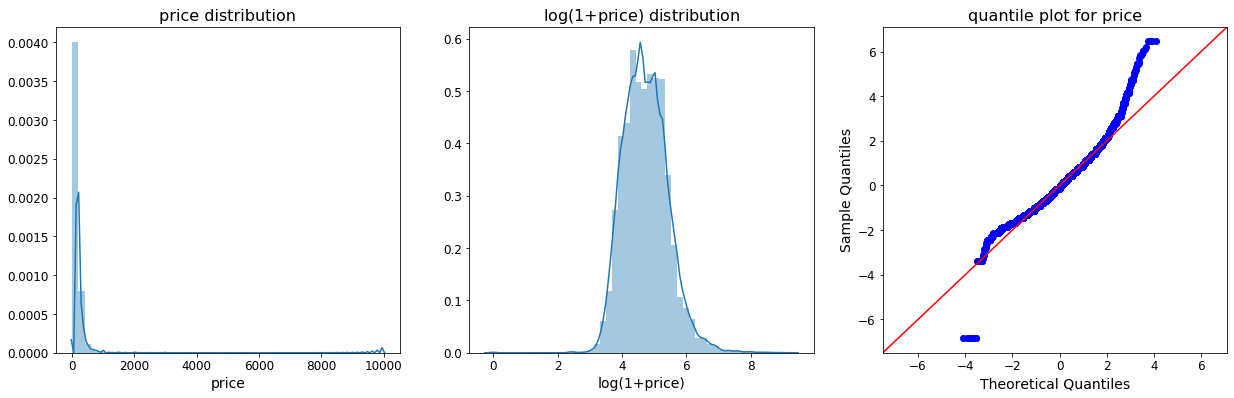

In [77]:
import statsmodels
import statsmodels.api as sm
import scipy.stats as stats

fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(Combined_df['price'], ax=axes[0])
axes[0].set_title('price distribution', fontsize=16)
sns.distplot(np.log1p(Combined_df['price']), ax=axes[1])
axes[1].set_title('$\log$(1+price) distribution', fontsize=16)
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(Combined_df['price']), stats.norm, fit=True, line='45', ax=axes[2]);
axes[2].set_title('quantile plot for price',  fontsize=16);

The target (price) has a highly right-skewed distribution. This can cause problems for machine learning algorithms such as linear regression due to the imbalance. A log transformation makes distribution look much closer to normal.

In [78]:
pd.concat((Combined_df[['price']].describe(), 
                np.log1p(Combined_df[['price']]).rename(columns={'price': 'log(1+price)'}).describe()), axis=1)

,price,log(1+price)
count,42783.000000,42783.000000
mean,152.184466,4.736383
std,235.080321,0.693363
min,0.000000,0.000000
25%,69.000000,4.248495
50%,106.000000,4.672829
75%,175.000000,5.170484
max,10000.000000,9.210440


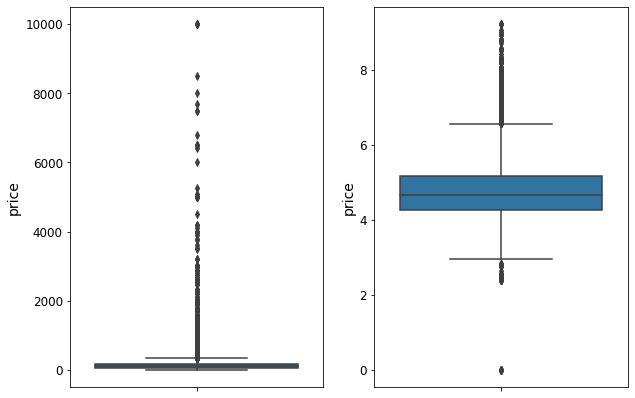

In [79]:
fig, axes = plt.subplots(1,2, figsize=(10,7))
sns.boxplot(y=Combined_df['price'], ax=axes[0])
sns.boxplot(y=np.log1p(Combined_df['price']), ax=axes[1]);

It seems most log price is congested around 5 and the it seems we have some outliers. We could consider removing them but I will not touch it unless I use liniear regression model.

In [80]:
y_train = np.log1p(y_train)
Combined_df['price'] = Combined_df['price'].map(lambda x: np.log1p(x))

## Numerical Variables

In [81]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42783 entries, 0 to 42782
Data columns (total 11 columns):
neighbourhood_group               42783 non-null object
room_type                         42783 non-null object
minimum_nights                    42783 non-null int64
number_of_reviews                 42783 non-null int64
reviews_per_month                 42783 non-null float64
calculated_host_listings_count    42783 non-null int64
availability_365                  42783 non-null int64
review_time_gap                   42783 non-null int64
subway_distance                   42783 non-null float64
adj_cnt                           42783 non-null float64
pop_density                       42783 non-null float64
dtypes: float64(4), int64(5), object(2)
memory usage: 3.6+ MB


In [82]:
# numerical features - price : 10
numerical_features = Combined_df.select_dtypes(exclude=[object]).columns.values[:-1] 

# categorical features : neighbourhood_group & room_type: 2
categorical_features = Combined_df.select_dtypes(include=[object]).columns.values

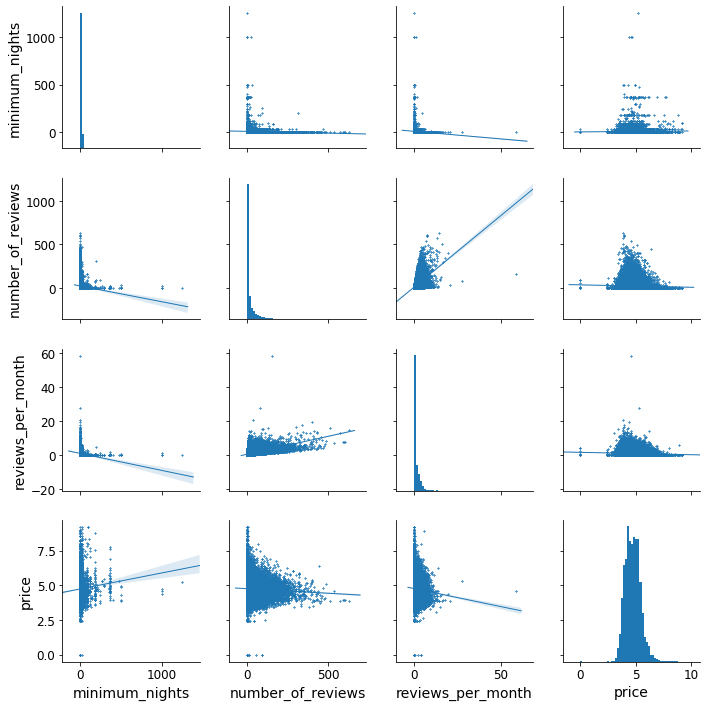

In [83]:
g = sns.pairplot(Combined_df[np.concatenate([numerical_features[:3], ['price']])], 
                 kind='reg', markers="x", diag_kws=dict(bins=50), 
                 plot_kws=dict(scatter_kws=dict(s=1.5), line_kws=dict(lw=1)))
g.fig.set_size_inches(10, 10)

for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    ax.set_xlabel(xlabel, rotation = 0, fontsize=14)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ax.set_ylabel(ylabel, rotation = 90, fontsize=14)

- It seems that `minimum_nights`, `number_of_reviews`, and `reviews_per_month` are all actually categorical (ordinal) variable

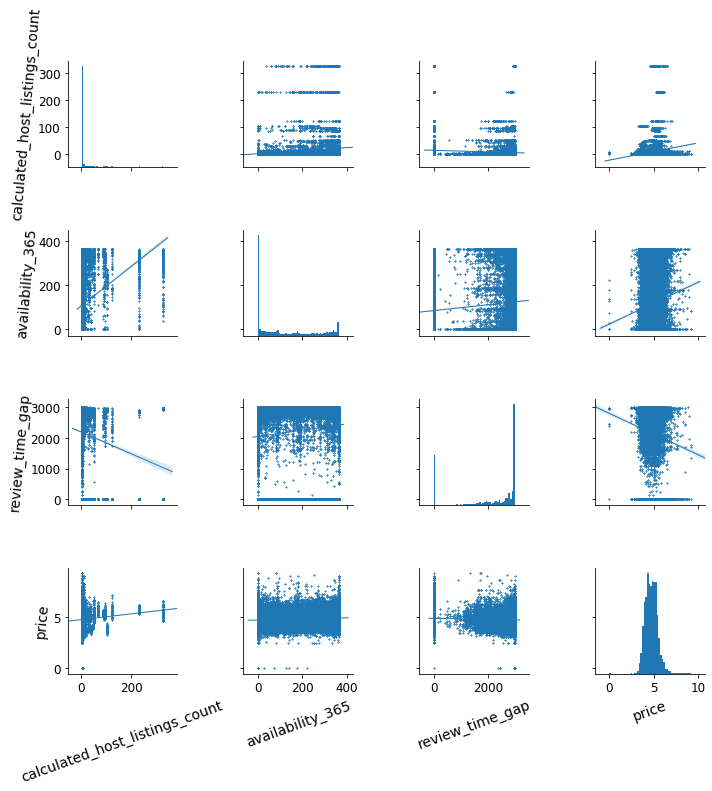

In [84]:
g = sns.pairplot(Combined_df[np.concatenate([numerical_features[3:6], ['price']])], 
                 kind='reg', markers="x", diag_kws=dict(bins=50),
                 plot_kws=dict(scatter_kws=dict(s=1.5), line_kws=dict(lw=1)))
g.fig.set_size_inches(10, 10)

for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    ax.set_xlabel(xlabel, rotation = 20, fontsize=14)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ax.set_ylabel(ylabel, rotation = 85, fontsize=14)

- Likewise, `calculated_host_listings`, `availability`, `review_time_gap` are all ordinal categorical variables.

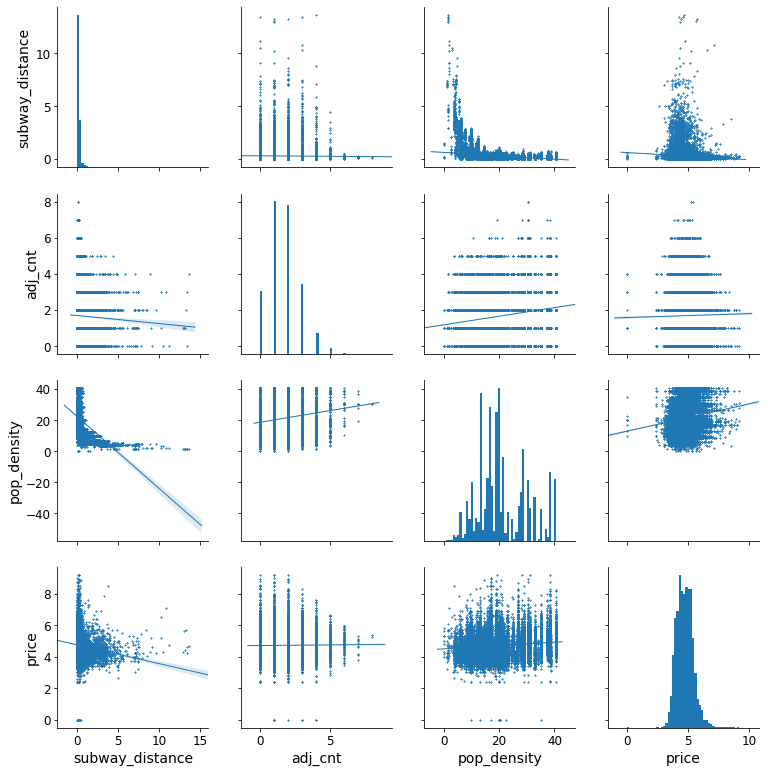

In [85]:
g = sns.pairplot(Combined_df[np.concatenate([numerical_features[6:], ['price']])], 
                 kind='reg', markers="x", diag_kws=dict(bins=50),
                 plot_kws=dict(scatter_kws=dict(s=1.5), line_kws=dict(lw=1)))
g.fig.set_size_inches(11, 11)

for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    ax.set_xlabel(xlabel, rotation = 0, fontsize=14)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ax.set_ylabel(ylabel, rotation = 90, fontsize=14)

- `adj_cnt` is ordinal categorical variable

In [86]:
(len(X_train['minimum_nights'].unique()), 
 len(X_train['number_of_reviews'].unique()), 
 len(X_train['reviews_per_month'].unique()),
 len(X_train['review_time_gap'].unique()), 
 len(X_train['availability_365'].unique()), 
 len(X_train['calculated_host_listings_count'].unique()),
 len(X_train['adj_cnt'].unique()))

(103, 383, 923, 1731, 366, 47, 9)

Wow, it turns out only `subway_distance` and `pop_density` are truly numerical variables. This is a bit of formidable situation because except `adj_cnt`, all features have many levels! For example, `review_time_gap` has 1731 levels! However, these features are not just nominal categorical variables but are ordinal categorical variables which means they have orders in levels. For example, `availability_365 = 5` is larger than `availability_365 = 2` (and maybe is a good thing for some people). That is, their order has a meaning!. For this reason, I will treat them as numerical values. 

With this regard, other categorical values - `neighbourhood_group` and `room_type` - do not imply any meaning when it comes to order of levels. You can't aline or compare "Manhattan" and "Brooklyn" as is, for exmaple. 

Now, let us focus on the distribution of variables and its scales since we are treating them as numerical variables.

In [87]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=len(X_train), output_distribution='normal')
num_scaled = qt.fit_transform(X_train[numerical_features])

num_scaled_df = pd.DataFrame(num_scaled, columns=numerical_features)

In [88]:
num_scaled_df.describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_time_gap,subway_distance,adj_cnt,pop_density
count,42783.000000,42783.000000,42783.000000,42783.000000,42783.000000,42783.000000,4.278300e+04,42783.000000,42783.000000
mean,-1.029941,-0.780021,-0.780381,-3.054937,-1.411721,-0.777827,7.706276e-09,-0.491987,0.114256
std,2.544550,2.342059,2.342325,3.024370,2.960328,2.348598,1.000397e+00,1.997487,1.351544
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338e+00,-5.199338,-5.199338
25%,-5.199338,-0.648132,-0.680866,-5.199338,-5.199338,-0.674600,-6.744898e-01,-0.520177,-0.667628
50%,-0.305245,-0.020948,-0.003662,-5.199338,0.000762,-0.001201,2.782916e-15,0.324393,0.001816
75%,0.711061,0.678320,0.675593,0.609892,0.673718,0.669680,6.744898e-01,0.324393,0.641568
max,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338e+00,5.199338,5.199338


Since some distributions are bimodal, let us move distributions so each mean is located at 0.

In [89]:
from sklearn.base import BaseEstimator, TransformerMixin

class Move_Distribution_By_Mean(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # Nothinng to do 
    def transform(self, X, y=None):
        for i in range(X.shape[1]):
            X[:, i] = X[:, i] - X[:, i].mean()
        return X 

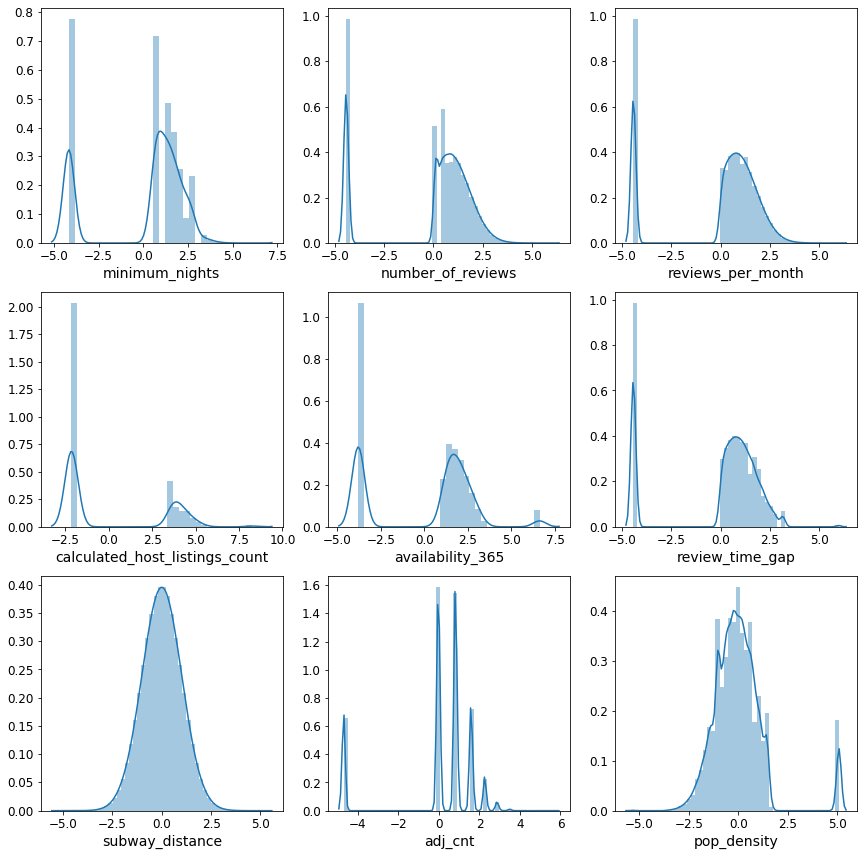

In [90]:
num_scaled_df = Move_Distribution_By_Mean().transform(num_scaled_df.values)

num_scaled_df = pd.DataFrame(num_scaled_df, columns=numerical_features)

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

row, col = 0, 0
for feature in numerical_features:
    sns.distplot(num_scaled_df[feature], ax=axs[row, col])
    col += 1
    if col % 3 == 0:
        col = 0
        row += 1
        
plt.tight_layout()

In [91]:
num_scaled_df.describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_time_gap,subway_distance,adj_cnt,pop_density
count,4.278300e+04,4.278300e+04,4.278300e+04,4.278300e+04,4.278300e+04,4.278300e+04,4.278300e+04,4.278300e+04,4.278300e+04
mean,1.023057e-16,3.628862e-17,5.779606e-17,6.111767e-17,2.584215e-16,1.826887e-17,1.320341e-17,3.786638e-17,2.524425e-17
std,2.544550e+00,2.342059e+00,2.342325e+00,3.024370e+00,2.960328e+00,2.348598e+00,1.000397e+00,1.997487e+00,1.351544e+00
min,-4.169396e+00,-4.419317e+00,-4.418956e+00,-2.144401e+00,-3.787616e+00,-4.421511e+00,-5.199338e+00,-4.707350e+00,-5.313593e+00
25%,-4.169396e+00,1.318888e-01,9.951525e-02,-2.144401e+00,-3.787616e+00,1.032268e-01,-6.744898e-01,-2.818926e-02,-7.818840e-01
50%,7.246962e-01,7.590730e-01,7.767194e-01,-2.144401e+00,1.412483e+00,7.766258e-01,-7.706273e-09,8.163801e-01,-1.124396e-01
75%,1.741002e+00,1.458340e+00,1.455975e+00,3.664828e+00,2.085439e+00,1.447507e+00,6.744897e-01,8.163801e-01,5.273120e-01
max,6.229279e+00,5.979358e+00,5.979719e+00,8.254274e+00,6.611059e+00,5.977164e+00,5.199338e+00,5.691325e+00,5.085082e+00


Now, let's see correlation between numerical features and the target.

In [92]:
Combined_df[numerical_features] = num_scaled_df.values

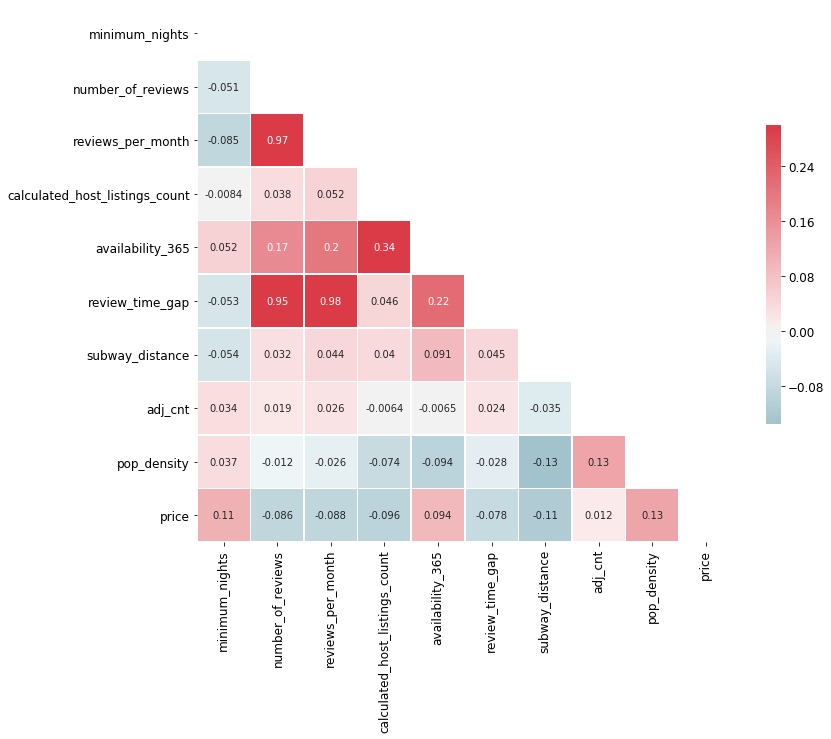

In [93]:
corr_matrix = Combined_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.autoscale();

- `number_of_reviews`, `reviews_per_month`, and `review_time_gap` are highly correlated (close to 1). In this case, we would better off remove redundancy and choose one feature among them. Since they are highly correlated, `review_per_month` would act as a surrogate and we will have a dimension reduction effect. 
- Most features are very mildly correlated to the target, price. Population density shows relatively strong correlation and it proves that my guess was correct that where more people are should be more expensive simply based on 'supply-and-demand' theory. 
- One of our engineered feature - `subway_distance` - also shows relatively strong correlation (negative) and again, inducive reasoning serves well in this case. 
- However, at a facial value, `adj_cnt` does not show strong correlation to price. We will have to see once we choose the model if this is still the case.

In [94]:
X_train[numerical_features] = num_scaled_df.values
# drop redundant features
X_train.drop(columns=['number_of_reviews', 'review_time_gap'], inplace=True)

In [95]:
X_train.head(3)

,neighbourhood_group,room_type,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,subway_distance,adj_cnt,pop_density
0,Manhattan,Entire home/apt,1.741002,1.068696,-2.144401,1.163797,-1.777136,0.816380,0.527312
1,Brooklyn,Entire home/apt,1.870678,0.616238,-2.144401,-3.787616,-0.913208,-0.028189,-1.491732
2,Queens,Private room,1.741002,1.508025,4.181345,2.164719,1.528985,0.816380,-2.140384


## Categorical Variables

In [96]:
categorical_features

array(['neighbourhood_group', 'room_type'], dtype=object)

In [97]:
cat_df = X_train[categorical_features].copy()
cat_df.head(3)

,neighbourhood_group,room_type
0,Manhattan,Entire home/apt
1,Brooklyn,Entire home/apt
2,Queens,Private room


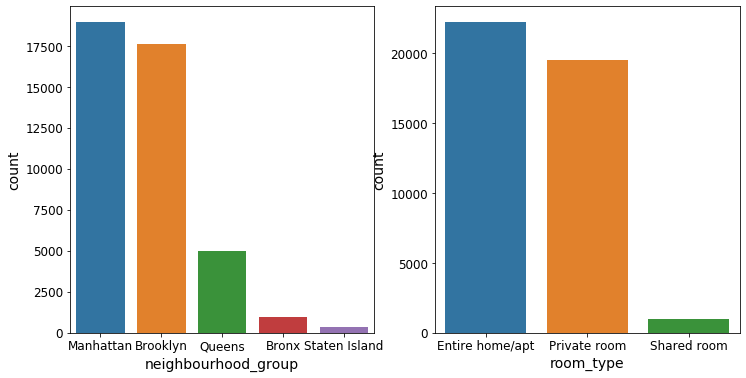

In [98]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.countplot(x="neighbourhood_group", data=cat_df)

plt.subplot(122)
sns.countplot(x="room_type", data=cat_df);

We have already seen the left plot and this is a confirmation that training set is indeed reflecting the true distribution of neighborhood group. On the other hand, the right plot shows which room_type an airbnb provides.  Moslty it is either 'Entire home/apt' or 'Private room' and rarely is 'Shared room'. Since they only have 5 and 3 levels respectively and are nominal categorical variables, we can use the one-hot encoding trick. 

In [99]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
cat_1hot = cat_encoder.fit_transform(cat_df)
cat_1hot

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [100]:
cat_1hot.shape

(42783, 8)

In [101]:
# finalize training data
X_train.drop(columns=categorical_features, inplace=True)

X_train = pd.concat([X_train, 
                     pd.DataFrame(cat_1hot,
                                 columns=np.hstack( (cat_encoder.categories_[0], cat_encoder.categories_[1])))
                    ], axis=1)
X_train.head(3)

,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,subway_distance,adj_cnt,pop_density,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
0,1.741002,1.068696,-2.144401,1.163797,-1.777136,0.816380,0.527312,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.870678,0.616238,-2.144401,-3.787616,-0.913208,-0.028189,-1.491732,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.741002,1.508025,4.181345,2.164719,1.528985,0.816380,-2.140384,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [102]:
X_train.shape

(42783, 15)

# Data Preparation

Basically this section is the summary of all data preparation procedures we've done so far. You can run the notebook from here. 

In [103]:
df = pd.read_csv('./new-york-city-airbnb-open-data/AB_NYC_2019.csv', 
                 parse_dates=['last_review'])

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import QuantileTransformer

# train : test = 87.5 : 12.5
split = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
for train_index, test_index in split.split(df, df["neighbourhood_group"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    
X_train = strat_train_set.drop(columns=['price'])
y_train = strat_train_set['price'].values
X_test = strat_test_set.drop(columns=['price'])
y_test = strat_test_set['price'].values

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((42783, 15), (42783,), (6112, 15), (6112,))

In [105]:
from sklearn.base import BaseEstimator, TransformerMixin

class Fill_Na(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # Nothing to do
    def transform(self, X, y=None):
        try:
            X = X.values
        except:
            pass 
            
        reviews_per_month_ix, name_ix = 1, 8
        # filling 'review_per_month'
        X[:, reviews_per_month_ix] = \
                np.array([num if str(num) != 'nan' else 0 
                      for num in X[:, reviews_per_month_ix]])

        # fill 'name'
        array = X.copy()
        X[:, name_ix] = \
            np.array([name if str(name) != 'nan' else "" 
                      for name in array[:, name_ix]])
        
        return X

In [106]:
from sklearn.impute import SimpleImputer
## for numerical values
class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numerical_imputer = SimpleImputer(strategy="median")
        self.categorical_imputer = SimpleImputer(strategy="most_frequent")
    def fit(self, X, y=None):
        self.numerical_imputer.fit(X[:, :4])
        self.categorical_imputer.fit(X[:, 6:])
        return self
    def transform(self, X, y=None):
        X[:, :4] = self.numerical_imputer.transform(X[:, :4])
        X[:, 6:] = self.categorical_imputer.transform(X[:, 6:])
        return X

In [107]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in mile between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles. Use 6371 for kilometers
    return c * r


def make_subway_distance(X): # X is np.arrays with 'longitude' and 'latitude'
    # read subway data
    subway_df = pd.read_csv('nyc_subway.csv')

    # extract locational innformation
    longitudes = subway_df['the_geom'].str.findall(r'-?\d+.\d+').map(lambda x: x[0]).astype(float).values
    latitudes = subway_df['the_geom'].str.findall(r'-?\d+.\d+').map(lambda x: x[1]).astype(float).values
    subway_stations = np.c_[longitudes, latitudes]

    ######## Helper ####################
    def find_closest_distance(lon_df, lat_df):
        distance = np.inf
        for ind, (lon, lat) in enumerate(subway_stations):
            current_distance = haversine(lon_df, lat_df, lon, lat)
            if current_distance < distance:
                distance = current_distance
        return distance # return the minimum distance 
    #####################################

    closest_distance = \
            pd.DataFrame(X, columns=['longitude', 'latitude'])\
                            .apply(lambda row: find_closest_distance(*row), axis=1)
    
    return closest_distance.values

In [108]:
from nltk.corpus import wordnet as wn
import re

def make_adj_cnt(X): # X is np.ndarray - 'name'
    # get all adjectives from wordnet
    adj_list= np.array(list(
                    set(list(syns.lemma_names()[0] for syns in list(wn.all_synsets('a'))))
                   )) # we do not want redundant words
    
    pos_df = pd.read_fwf('positive-words.txt').iloc[33:] # word start from index 33
    pos_adjectives = np.squeeze(pos_df.values)
    # combine positive word lists
    adjectives = np.union1d(pos_adjectives, adj_list)
    
    # after examine the data, hand-filter some words
    for no_adj in ['.22_caliber', '.38_caliber', '.45_caliber', 'in', 'apt']: 
        ind = np.argwhere(adjectives == no_adj)
        adjectives = np.delete(adjectives, ind)
    
    ####### helpers #######
    def clean_word_list(text):
        clean_text = re.sub(r"['\",.#@$!?%^&*()\[\]~{}/\\<>`+=\-_]", "", text)
        clean_words = clean_text.split(' ')
        return clean_words

    def count_adjective(text):
        words = clean_word_list(text)
        return np.sum([1 for word in words if word.lower() in adjectives])
    ########################
    X_df = pd.Series(X).map(lambda x: count_adjective(x))
    
    return X_df.values

In [109]:
def make_pop_density(X):
    nyc_area_df = pd.read_csv('nynta.csv')
    nyc_pop_df = pd.read_csv('nyc_pop.csv')

    neighborhood_df = nyc_pop_df[['NTA Name', 'NTA Code', 'Population']].\
                                        merge(nyc_area_df[['NTACode', 'Shape_Area', 'the_geom']],
                                        left_on="NTA Code", 
                                        right_on="NTACode").drop(columns=['NTACode'])
    # We don't need no population rows
    neighborhood_df = neighborhood_df[neighborhood_df['Population'] !=0]

    # make list of (neighborhood, neighborhood_group) from neighborhood_df
    # So we can cross-match name and borough together.
    neighborhood_df_sub = pd.concat([neighborhood_df['NTA Name'], neighborhood_df['NTA Code'].map(lambda x: x[:2])], axis=1)
    neighborhood_nta_values = neighborhood_df_sub.values

    ##### helper #######
    def find_matches(neigh_group_from_data, neigh_from_data):
        matches = dict()
        for ind, (neigh, neigh_group) in enumerate(neighborhood_nta_values):
            if neigh_from_data in neigh:
                # only when neighbour groups match
                if (neigh_group_from_data == "Manhattan") and (neigh_group =="MN"):
                    matches[neigh] = ind
                elif (neigh_group_from_data == "Brooklyn") and (neigh_group =="BK"):
                    matches[neigh] = ind
                elif (neigh_group_from_data == "Bronx") and (neigh_group =="BX"):
                    matches[neigh] = ind
                elif (neigh_group_from_data == "Queens") and (neigh_group =="QN"):
                    matches[neigh] = ind
                elif (neigh_group_from_data == "Staten Island") and (neigh_group =="SI"):
                    matches[neigh] = ind
        return matches
    ##################

    # make list of dictionary that has neighbourhood and matching neighbourhood(s)
    # from neighborhood_df_sub
    new_list = [{nb : find_matches(gr, nb)} for (gr, nb) in X[:, [6, 7]]]

    # fill in missings due to typors or spelling difference
    new_new_list = []
    for ele in new_list:
        for k, v in ele.items():
            if k== "Manhattan Beach":
                new_new_list.append({k:{'Sheepshead Bay-Gerritsen Beach-Manhattn Bch': 39}})
            elif k== "Mariners Harbor":
                new_new_list.append({k:{"Mariner's Harbor-Arlington-Port Ivory-Graniteville": 181}})
            elif k== "New Dorp Beach":
                new_new_list.append({k:{'New Dorp-Midland Beach': 190}})
            elif k== "Sea Gate":
                new_new_list.append({k:{'Seagate-Coney Island':41}})
            elif k== "Tribeca":
                new_new_list.append({k:{'SoHo-TriBeCa-Civic Center-Little Italy': 106}})
            else:
                new_new_list.append({k:v})
    # remove 'new_list'
    del new_list

    # make check list for cases of missing match
    check_list = []
    for ele in new_new_list:
        for key, value in ele.items():
            if len(value) == 0:
                check_list.append(key)

    check_list = sorted(list(set(check_list)))

    # list of population_density 
    map_list = []
    for ele in new_new_list:
        for k, v in ele.items():
            if v != {}:
                map_list.append(
                         np.sum([neighborhood_df['Population'].iloc[values] for values in v.values()]) \
                         / np.sum([neighborhood_df['Shape_Area'].iloc[values] for values in v.values()]) \
                         * 1e4) # Since we need relative values, multiplying 10,000 doesn't affect the quality
            else: # if no matches, append 0
                map_list.append(0.0) 

    # extract locational information from `neighborhood_df`            
    longitudes = neighborhood_df['the_geom'].str.findall(r'-?\d+.\d+').map(lambda x: x[0]).astype(float).values
    latitudes = neighborhood_df['the_geom'].str.findall(r'-?\d+.\d+').map(lambda x: x[1]).astype(float).values
    borough = np.c_[longitudes, latitudes]
    # delete used lists
    del longitudes, latitudes

    ##### helper ############
    # get population density from the neighborhood closest to those neighborhood
    # that doesn't have assess to the info due to no match
    def find_closest(row):
        len_borough = len(borough)
        array = [haversine(*row, *borough[i]) for i in range(len_borough)]
        closest_ind = np.argmin(array)
    #     return closest_ind
        return (neighborhood_df.iloc[closest_ind]['Population'] 
                    / neighborhood_df.iloc[closest_ind]['Shape_Area'] * 1e4)
    #########################

    X_df = pd.DataFrame(X[:, [7, 4, 5]], columns=['neighbourhood', 'longitude', 'latitude'])

    filling_pop_density = \
        X_df[X_df['neighbourhood'].isin(check_list)][['longitude', 'latitude']].\
                                        apply(lambda row: find_closest(row), axis=1)

    # Now fill the gap in `map_list`
    for ind in filling_pop_density.index.to_list():
        map_list[ind] = filling_pop_density[ind]
        
    pop_density = map_list
    
    # delete variables
    del map_list, X_df, filling_pop_density

    return pop_density




In [110]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None): # X taking all 'numerical_features'
        # add: 'subway_distance' 
        subway_distance = make_subway_distance(X[:, [4, 5]]) # pass 'longitude' & 'latitutde'
        # add: 'adj_cnt'
        adj_cnt = make_adj_cnt(X[:, 8]) # pass 'name' feature
        # add: 'pop_density'
        pop_density = make_pop_density(X)
        ## drop 'longitude', 'latitude', 'neighbourhood_group', 'neighbourhood', 'name'
        ## from numerical features
        return np.c_[X[:, :4], subway_distance, adj_cnt, pop_density]

In [111]:
from sklearn.base import BaseEstimator, TransformerMixin

class Move_Distribution_By_Mean(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # Nothinng to do 
    def transform(self, X, y=None):
        for i in range(X.shape[1]):
            X[:, i] = X[:, i] - X[:, i].mean()
        return X 

## Pipeline

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

numerical_features = ['minimum_nights', 'reviews_per_month', 
                      'calculated_host_listings_count', 'availability_365',
                      'longitude', 'latitude', 
                      'neighbourhood_group', 'neighbourhood', 'name' # for adding features
                     ]

categorical_features = ['neighbourhood_group', 'room_type']

num_pipeline = Pipeline([
    ('fill_na', Fill_Na()),
    ('imputer', Imputer()),
    ('attribs_adder', CombinedAttributesAdder()),
    ('qt_scaler',  QuantileTransformer(n_quantiles=len(X_train), output_distribution='normal')),
    ('move_features', Move_Distribution_By_Mean()) 
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(sparse=False))
])

preprocessing_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", cat_pipeline, categorical_features)
])

In [113]:
X_train_prepared = preprocessing_pipeline.fit_transform(X_train)
X_train_prepared.shape

(42783, 15)

In [114]:
columns = ['minimum_nights', 'reviews_per_month',
           'calculated_host_listings_count', 'availability_365',
           'subway_distance', 'adj_cnt', 'pop_density', 'Bronx', 'Brooklyn',
           'Manhattan', 'Queens', 'Staten Island', 'Entire home/apt',
           'Private room', 'Shared room']
pd.DataFrame(X_train_prepared, columns=columns).head(10)

,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,subway_distance,adj_cnt,pop_density,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
0,1.741002,1.068696,-2.144401,1.163797,-1.777136,0.816380,0.527312,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.870678,0.616238,-2.144401,-3.787616,-0.913208,-0.028189,-1.491732,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.741002,1.508025,4.181345,2.164719,1.528985,0.816380,-2.140384,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.235630,0.630474,-2.144401,2.003646,-1.927254,0.816380,-0.259750,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.724696,0.698468,-2.144401,-3.787616,0.709968,0.816380,0.324919,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.724696,1.034987,4.299695,-3.787616,0.370576,1.586645,-0.026139,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,1.545261,1.305091,-2.144401,-3.787616,0.516390,-0.028189,5.085082,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,0.724696,1.300893,-2.144401,1.654030,-0.713137,-0.028189,0.264648,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,2.636812,-4.418956,5.417716,2.603386,0.845837,0.816380,5.085082,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,1.235630,0.952934,-2.144401,-3.787616,-0.854245,0.816380,-0.585045,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Great! Now we have a pipeline that prepares data!

# Modeling

## Evaluation Metric Selection

As we noticed [earlier](#Price-distribution), our target variable price is highly right skewed and in this case machine learning models can perform poorly due to the scaling issue on the response. Therefore, we will consider instead $\log$price as our target. It makes target distribution much more like normal but it comes at a cost: now we can't inteprete the target value easily. Since I am considering gradient base models, using mae (mean absolute error) will make learning harder. Therefore, I will use **obsective function as msle (mean squared logarithmic error)** and **interpret (evalute) the results with mae**. Reference the form of metrics below:

$$ 
    MSLE(y, \hat{y)} = \frac{1}{n_{samples}}\sum_{i=0}^{n_{samples} - 1}[\log(1+y_i) - \log(1+\hat{y}_i) ]^2 \\
    MAE(y, \hat{y)} = \frac{1}{n_{samples}}\sum_{i=0}^{n_{samples} - 1}|y_i - \hat{y}_i|
$$


In [115]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

## Model Selection

From what I observed in EDA section - that most features are categorical even though we treat most of them as numerical, many transformed distributions are bimodal, and most features show weak correlation to the target ($\log$(price)), simpler models such as linear regression would not show a good performance. But we have to see what data speaks, we will consider following models. 

- Linear Regression
- ElasticNet regression
- Random Forest
- XGBoost (Gradient Boosting)
- MLP (Multilayer Perceptron) (TBD)

Let us try with a default models.

In [116]:
def warn(*args, **kwargs): # force sklearn to shut off warning on LDA
    pass
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [117]:
def build_mlp_model(n_hidden=1, n_neurons=32, learning_rate=3e-3, input_shape=[15]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Nadam(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

### Default models

For `mlp_model` we use 1 layer with 32 neurons.

In [120]:
# because MSLE gives error, we transform y_train with logarithm
log_y_train = np.log1p(y_train)

models = []
models.append(('lin_reg', LinearRegression()))
models.append(('Ela_reg', ElasticNet()))
models.append(('rdf_reg', RandomForestRegressor(n_estimators=100, random_state=42))) # due to future warning
models.append(('xgb_reg', XGBRegressor(objective='reg:squarederror', random_state=42))) # due to depreciation err
# models.append(('mlp_reg')) 

results = []
names = []
kfold = KFold(n_splits=5, random_state=42)

for name, model in models:
    cv_results = cross_val_score(model, X_train_prepared, log_y_train, # because MSLE gives error
                                 cv=kfold, scoring="neg_mean_squared_error") # MSLE gives error
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {-cv_results.mean():.4f} ({cv_results.std():.4f})" # because cross_val has "greater the better"
                                                                       # policy, it spits negative scores
    print(msg)
    
mlp_results = []
for train_idx, test_idx in kfold.split(X_train_prepared):
    model=build_mlp_model()
    model.fit(X_train_prepared[train_idx], log_y_train[train_idx], epochs=20, verbose=0)
    
    mlp_results.append(model.evaluate(X_train_prepared[test_idx], log_y_train[test_idx], verbose=0))

print(f"mlp_reg: {np.mean(mlp_results):.4f} ({np.std(mlp_results):.4f})")

lin_reg: 0.2485 (0.0079)
Ela_reg: 0.4808 (0.0094)
rdf_reg: 0.2090 (0.0099)
xgb_reg: 0.2120 (0.0086)
mlp_reg: 0.2336 (0.0098)


`RandomForestRegressor` shows the lowest MSLE but `XGBRegressor` shows second lowest MSLE and lower "Standard Deviation". For this reason, let us fine-tune two models and compare the best estimator scores.

## Fine-Tuning the Model (RF)

> `note`: After several `RandomizedSearchCV` runs, I narrowed down the parameter ranges

In [138]:
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

param_dist = dict(n_estimators=[250, 300],
                  objective=['reg:squarederrror'], 
                  max_depth = [15], 
                  min_samples_split = [4],
#                   min_samples_leaf = [1],  # default
                  max_features = [7, 8, 9])

rdf_reg = RandomForestRegressor(random_state=42, n_jobs=16)

rdf_grid_search = GridSearchCV(rdf_reg, param_dist, cv=5,  
                               scoring='neg_mean_squared_error', 
                               return_train_score=True, iid=False)

rdf_grid_search.fit(X_train_prepared, log_y_train);

In [139]:
rdf_grid_search.best_params_

{'max_depth': 15,
 'max_features': 7,
 'min_samples_split': 4,
 'n_estimators': 250}

In [140]:
-rdf_grid_search.best_score_

0.19722318302697228

In [141]:
rdf_reg = rdf_grid_search.best_estimator_

## Fine-Tuning the model (XGB)

> `note`: After several `RandomizedSearchCV` runs, I narrowed down the parameter ranges

In [157]:
#TOD change param ranges
param_dist = dict(##################### determined hyper-parameters
                  n_jobs=[32],
                  objective=['reg:squarederror'],
                  random_state=[42],
                  verbose=[1],
                  n_estimators=[200],
                  subsample = [0.9],
                  colsample_bytree = [0.65],
                  reg_alpha = [1],
                  reg_lambda = [1],
                  ##################### until here
                  learning_rate = [0.005, 0.075],
                  max_depth = [8, 9, 10]
                  )

xgb_reg = XGBRegressor()

xgb_grid_search = GridSearchCV(xgb_reg, param_dist, cv=5,
                               scoring='neg_mean_squared_error', 
                               return_train_score=True, iid=False)

xgb_grid_search.fit(X_train_prepared, log_y_train);

In [158]:
xgb_grid_search.best_params_

{'colsample_bytree': 0.65,
 'learning_rate': 0.075,
 'max_depth': 8,
 'n_estimators': 200,
 'n_jobs': 32,
 'objective': 'reg:squarederror',
 'random_state': 42,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'subsample': 0.9,
 'verbose': 1}

In [159]:
-xgb_grid_search.best_score_

0.19245146280636238

In [161]:
xgb_reg = xgb_grid_search.best_estimator_

After fine tuning it is clear that Extreme Gradient Boosting Regressor is the winner based on 5-fold cross validation score. (xgb: 0.1924 vs. rfd: 0.1972). Therefore __we choose XGBRegressor as our final model__.


# Evaluation


First, let us prepare the test set using `preprocessing_pipeline` we created.

In [163]:
X_test_prepared = preprocessing_pipeline.transform(X_test)

log_y_test = np.log1p(y_test)

In [171]:
pd.DataFrame(X_test_prepared, columns=columns).isnull().sum()

minimum_nights                    0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
subway_distance                   0
adj_cnt                           0
pop_density                       0
Bronx                             0
Brooklyn                          0
Manhattan                         0
Queens                            0
Staten Island                     0
Entire home/apt                   0
Private room                      0
Shared room                       0
dtype: int64

In [173]:
np.isnan(log_y_test).sum()

0

Good! All work fine! Now let us evaluate the model on test set.

In [174]:
log_y_pred = xgb_reg.predict(X_test_prepared)

In [177]:
np.exp(log_y_pred)

array([109.05071 ,  65.69729 ,  86.86287 , ..., 120.984436,  70.46664 ,
        70.37513 ], dtype=float32)

In [176]:
np.exp(log_y_pred) - 1

array([108.05071 ,  64.69729 ,  85.86287 , ..., 119.984436,  69.46664 ,
        69.37513 ], dtype=float32)

In [178]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

log_y_pred = xgb_reg.predict(X_test_prepared) # log(1+y_pred)
y_pred = np.exp(log_y_pred) - 1  # log_y_pred = log(1+y_pred) -> y_pred = e^(log_y_pred) - 1


# Mean Squared Log Error
msle = mean_squared_error(log_y_test, log_y_pred)
# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

In [182]:
print(f"Mean Squared Log Error on test data is : {msle: .5f} (in log($+1))")
print(f"Mean Absolute Error on test data is : {mae: .5f} (in $)")

Mean Squared Log Error on test data is :  0.20951 (in log($+1))
Mean Absolute Error on test data is :  61.58701 (in $)


Woah, average difference between true price and predicted price is about \\$ 61 and it does not sound happy. However, before we weep over the result, let us do one more thing: go over well predicted data and poorly predicted data and find/guess the cause(s).

In [198]:
# make a dataframe that can be used for manual check
result_comparison = pd.DataFrame(np.c_[y_pred, y_test, np.abs(y_pred-y_test)], 
                                 columns=['pred', 'true', 'diff'])

test_result = pd.concat([result_comparison, 
                         X_test.drop(columns=['id', 'name', 'latitude', 'longitude',
                                              'host_id', 'host_name'])], axis=1)

In [208]:
bad = test_result[np.abs(test_result['pred'] - test_result['true']) >= mae]
good = test_result[np.abs(test_result['pred'] - test_result['true']) < mae]

In [212]:
bad.head(10)

,pred,true,diff,neighbourhood_group,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,108.050713,200.0,91.949287,Manhattan,Washington Heights,Entire home/apt,5,3,2018-08-23,0.26,1,30
14,257.529633,495.0,237.470367,Manhattan,East Village,Entire home/apt,2,66,2019-07-01,0.93,1,334
16,214.900742,280.0,65.099258,Manhattan,Gramercy,Entire home/apt,3,0,NaT,NaN,1,0
19,211.721222,350.0,138.278778,Manhattan,East Village,Entire home/apt,3,0,NaT,NaN,1,0
21,196.115646,275.0,78.884354,Manhattan,Lower East Side,Entire home/apt,1,0,NaT,NaN,1,0
23,84.479416,150.0,65.520584,Manhattan,East Village,Private room,7,2,2018-10-28,0.23,2,45
25,207.547043,75.0,132.547043,Manhattan,SoHo,Entire home/apt,4,9,2018-10-17,0.53,1,0
32,205.955002,143.0,62.955002,Manhattan,East Village,Entire home/apt,30,0,NaT,NaN,1,57
33,75.640129,160.0,84.359871,Brooklyn,Williamsburg,Private room,5,0,NaT,NaN,1,0
38,134.076965,43.0,91.076965,Brooklyn,Clinton Hill,Entire home/apt,3,7,2018-08-08,0.38,2,0


In [213]:
good.head(10)

,pred,true,diff,neighbourhood_group,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1,64.697289,60.0,4.697289,Brooklyn,Bushwick,Private room,4,0,NaT,NaN,2,22
2,85.862869,75.0,10.862869,Brooklyn,Williamsburg,Private room,1,0,NaT,NaN,1,43
3,92.627243,80.0,12.627243,Manhattan,East Harlem,Private room,2,1,2019-07-01,1.00,3,181
4,63.237007,62.0,1.237007,Queens,Astoria,Private room,1,16,2019-06-21,3.38,7,308
5,58.461159,50.0,8.461159,Queens,Glendale,Private room,2,19,2019-07-01,1.38,1,337
6,125.054245,105.0,20.054245,Manhattan,Harlem,Entire home/apt,5,132,2019-06-20,2.09,1,12
7,103.597916,70.0,33.597916,Brooklyn,Sunset Park,Entire home/apt,18,19,2016-07-13,0.22,1,0
8,77.418556,78.0,0.581444,Brooklyn,South Slope,Private room,3,24,2019-05-27,0.33,3,28
9,221.952988,199.0,22.952988,Manhattan,Upper East Side,Entire home/apt,3,22,2019-07-01,1.58,1,329
10,59.459229,55.0,4.459229,Brooklyn,Canarsie,Private room,2,20,2019-06-24,1.40,3,177


> Okay, one thing pops out:
> ### Those which model poorly performed on are high-end property, which is rare in dataset (reference [borough wise price distribution](#Borough-wise-price-distribution) and [Price distribution](#Price-distribution)). Therefore, due to lack of data points, model poorly learned about expensive airbnbs and more focused on accurately predicting lower price properties. To see how it performs on 95 percentile data will confirms my theory. 

In [214]:
percentile_95_price = np.percentile(y_train, 95)
percentile_90_price = np.percentile(y_train, 90)

print(f"Threshold price at 95 percentile price: {percentile_95_price:.2f}")
print(f"Threshold price at 90 percentile price: {percentile_90_price:.2f}")

Threshold price at 95 percentile price: 350.00
Threshold price at 90 percentile price: 269.00


In [215]:
np.round_((np.where(y_train <= 350.00)[0].shape[0] / y_train.shape[0]) * 100, 2)

93.03


Okay, cut-off price at 95 percentile is \$ 380.45 and price above it is only 5% of entire test set.

In [216]:
percentile_95_idx = np.where(y_test <= 350.00)[0]

y_pred_95 = y_pred[percentile_95_idx]
y_test_95 = y_test[percentile_95_idx]

y_pred_upper_5 = y_pred[((~np.isin(np.arange(len(y_test)), percentile_95_idx)))]
y_test_upper_5 = y_test[(~np.isin(np.arange(len(y_test)), percentile_95_idx))]

mae_95 = mean_absolute_error(y_test_95, y_pred_95)
mae_upper_5 = mean_absolute_error(y_test_upper_5, y_pred_upper_5)

In [217]:
percentile_90_idx = np.where(y_test <= 269.00)[0]

y_pred_90 = y_pred[percentile_90_idx]
y_test_90 = y_test[percentile_90_idx]

y_pred_upper_10 = y_pred[((~np.isin(np.arange(len(y_test)), percentile_90_idx)))]
y_test_upper_10 = y_test[(~np.isin(np.arange(len(y_test)), percentile_90_idx))]

mae_90 = mean_absolute_error(y_test_90, y_pred_90)
mae_upper_10 = mean_absolute_error(y_test_upper_10, y_pred_upper_10)

In [218]:
print("====>> Entire Test Data <<=====")
print(f"Avearge price: {np.mean(y_test):.2f}")
print(f'MAE on 95 percentile test price: {mae: .2f}')
print()

print("====>> 95 Percentile Data <<=====")
print(f"Avearge price: {np.mean(y_test_95):.2f}")
print(f'MAE on 95 percentile test price: {mae_95: .2f}')
print()

print("====>> 90 Percentile Data <<=====")
print(f"Avearge price: {np.mean(y_test_90):.2f}")
print(f'MAE on 95 percentile test price: {mae_90: .2f}')
print()

print("====>> Upper 5 Percentile Data <<=====")
print(f"Avearge price: {np.mean(y_test_upper_5):.2f}")
print(f'MAE on upper 5 percentile test price: {mae_upper_5:.2f}')
print()

print("====>> Upper 10 Percentile Data <<=====")
print(f"Avearge price: {np.mean(y_test_upper_10):.2f}")
print(f'MAE on upper 5 percentile test price: {mae_upper_10:.2f}')

====>> Entire Test Data <<=====
Avearge price: 156.47
MAE on 95 percentile test price:  61.59

====>> 95 Percentile Data <<=====
Avearge price: 122.03
MAE on 95 percentile test price:  36.07

====>> 90 Percentile Data <<=====
Avearge price: 112.40
MAE on 95 percentile test price:  32.36

====>> Upper 5 Percentile Data <<=====
Avearge price: 761.89
MAE on upper 5 percentile test price: 510.17

====>> Upper 10 Percentile Data <<=====
Avearge price: 551.82
MAE on upper 5 percentile test price: 323.75


> ### Indeed, the mode performs really poorly on high price property prediction. Therefore, if we want to deploy the model in to production, it would be reasonable to use the model upto a certain predicted price, say 95 percentile price \\$ 350 on training data and airbnb whose predicted price above it should be examined by an expert. Therefore, you can think this model achieved 95% coverage with \\$ 36.07 MAE.